# Load Dataset

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchinfo import summary 

class create_tensor_dataset_localization(Dataset):
    def __init__(self, path = './dataset/realData/contact_detection_train.csv', transform = transforms.Compose([transforms.ToTensor()]), num_classes =5,
                 num_features_dataset = 14, num_features_lstm = 2, data_seq = 28, desired_seq = 28, localization= False, collision =False, dof = 7):
        self.path = path
        self.transform = transform
        self.num_features_dataset = num_features_dataset
        self.num_features_lstm = num_features_lstm
        self.data_seq = data_seq
        self.desired_seq = desired_seq
        self.dof = dof
        self.num_classes = num_classes
        self.localization = localization
        self.collision = collision
        if collision and localization:
            print('collision and localization cannot be true at the same time!')
            exit()
            

        self.read_dataset()
        self.data_in_seq()
        
    def __len__(self):
        return len(self.data_target)


    def __getitem__(self, idx: int):

        data_sample = torch.tensor(self.data_input.iloc[idx].values)
        data_sample = torch.reshape(data_sample, (self.dof ,self.num_features_lstm*self.desired_seq))

        target = self.data_target.iloc[idx]

        return data_sample, target


    def read_dataset(self):
        
        # laod data from csv file
        if self.path[(len(self.path)-3): len(self.path)] == 'csv':
            data = pd.read_csv(self.path)
        elif self.path[(len(self.path)-3): len(self.path)] == 'pkl':
            data = pd.read_pickle(self.path)
        # specifying target and data
        data_input = data.iloc[:,1:data.shape[1]]
        data_target = data.iloc[:,0]

        if not self.localization:
            data_target.loc[data_target.iloc[:]!=0] = 1

        if self.localization or self.collision:
            #if 0 in data_target.unique():
            data_input = data_input.loc[data_target.iloc[:]!=0, :]
            data_target = data_target.loc[data_target.iloc[:]!=0]
            data_target = data_target-1


        self.data_input = data_input.reset_index(drop=True)
        self.data_target = data_target.reset_index(drop=True)
        

    def data_in_seq(self):

        dof = self.dof

        # resorting item position
        data = np.array( range(0, self.num_features_dataset * self.data_seq ))
        data = data.reshape(self.data_seq, self.num_features_dataset)

        joint_data_pos = []
        for j in range(dof):
                 
            column_index = np.array(range(self.num_features_lstm))*dof +j
            row_index= range(self.data_seq-self.desired_seq, self.data_seq)
            join_data_matrix = data[:, column_index]
            joint_data_pos.append(join_data_matrix.reshape((len(column_index)*len(row_index))))
        
        joint_data_pos = np.hstack(joint_data_pos)

        # resorting (28,28)---> (4,28)(4,28)(4,28)(4,28)(4,28)(4,28)(4,28)

        self.data_input.columns = range(self.num_features_dataset * self.data_seq)
        self.data_input = self.data_input.loc[:][joint_data_pos]


# LSTM model

In [2]:
import argparse
import os
import time
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchmetrics import ConfusionMatrix, Accuracy
import matplotlib.pyplot as plt

'''
class ZScoreNormalization(nn.Module):
    def __init__(self):
        super(ZScoreNormalization, self).__init__()

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = torch.std(x, dim=1, keepdim=True)
         return (x - mean) / (std + 1e-6)  # Adding epsilon to avoid division by zero

class MinMaxNormalization(nn.Module):
    def __init__(self):
        super(MinMaxNormalization, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, dim=1, keepdim=True)[0]
        max_val = torch.max(x, dim=1, keepdim=True)[0]
        return (x - min_val) / (max_val - min_val + 1e-6)  # Min-Max normalization with epsilon

'''
def get_output(data_loader, model, device):
    model.eval()
    labels_pred = []
    labels_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch) # Return the prediction for each joint step (batch_size, joint_seq)

            preds = output.argmax(axis=1)  # shape: [batch_size]

            labels_pred.append(preds.cpu().numpy())
            labels_true.append(y_batch.cpu().numpy())

    # Convert lists to arrays
    labels_pred = np.concatenate(labels_pred, axis=0)
    labels_true = np.concatenate(labels_true, axis=0)

    # Convert numpy arrays back to tensors
    labels_pred = torch.tensor(labels_pred, dtype=torch.int64)  # Ensure long tensor for labels
    labels_true = torch.tensor(labels_true, dtype=torch.int64)  # Ensure long tensor for labels

    return labels_pred, labels_true
    
class ZScoreNormalization(nn.Module):
    def __init__(self):
        super(ZScoreNormalization, self).__init__()

    def forward(self, x):
        # Assuming input x has shape (batch_size, DOF,joint_seq)
        batch_size, DOF,joint_seq  = x.shape

        # Create a placeholder for the normalized output
        normalized_x = torch.zeros_like(x)
        
        # Apply normalization for each DOF independently
        for dof in range(DOF):
            # Normalize along the joint_seq dimension for each DOF
            mean = torch.mean(x[:, dof, :], dim=1, keepdim=True)
            std = torch.std(x[:, dof,:], dim=1, keepdim=True)
            normalized_x[:, dof, :] = (x[:, dof, :] - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero
        
        return normalized_x

class lstmBlock(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(lstmBlock, self).__init__()
        self.normalization = ZScoreNormalization()
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_features_lstm * time_seq,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Apply dropout only if more than one layer
        )
        # Fully connected layer (to predict contact for each joint step)
        if bidirectional:
            self.fc = nn.Linear(hidden_size*2, 1)  
        else:
            self.fc = nn.Linear(hidden_size, 1) 
        
    def forward(self, input):
        # Pass the input through the LSTM layer
        normalized_input = self.normalization(input)
        lstm_out, _ = self.lstm(normalized_input)
        # lstm_out shape: (batch_size, joint_seq, hidden_size)
        joint_step_outputs = self.fc(lstm_out)  # Shape: (batch_size, joint_seq, 1)
        return joint_step_outputs.squeeze()  # Return the prediction for each joint step (batch_size, joint_seq)

class lstmCNN(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(lstmCNN, self).__init__()
        self.normalization = ZScoreNormalization()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_features_lstm * time_seq,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Apply dropout only if more than one layer
        )

        # Define the 1D CNN layer (to apply after the LSTM)
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Define the 1D CNN layers (multiple layers for better feature extraction)
        self.cnn1 = nn.Conv1d(in_channels=lstm_output_size, out_channels=128, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        # Normalization and Pooling layers
        self.layer_norm = nn.LayerNorm(128)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer (to predict contact for each joint step)
        self.fc = nn.Linear(128, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # Pass the input through the LSTM layer
        normalized_input = self.normalization(input)
        lstm_out, _ = self.lstm(normalized_input)
        # Transpose LSTM output for CNN (batch_size, channels, sequence_length)
        cnn_input = lstm_out.permute(0, 2, 1)
        
        # Apply the stacked 1D CNN layers
        cnn_out = self.cnn1(cnn_input)
        cnn_out = nn.ReLU()(cnn_out)
        cnn_out = self.cnn2(cnn_out)
        cnn_out = nn.ReLU()(cnn_out)
        
        # Transpose CNN output back to (batch_size, sequence_length, channels)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # Fully connected layer
        cnn_out = self.dropout(cnn_out)

        # lstm_out shape: (batch_size, joint_dof, hidden_size)
        joint_step_outputs = self.fc(cnn_out)  # Shape: (batch_size, joint_dof, 1)
        
        return joint_step_outputs.squeeze()  # Return the prediction for each joint step (batch_size, joint_dof)

class cnnLSTM(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(cnnLSTM, self).__init__()
        self.normalization = ZScoreNormalization()
        
         # Define the 1D CNN layers
        self.cnn1 = nn.Conv1d(in_channels=num_features_lstm * time_seq, out_channels=64, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        self.attention = nn.Linear(lstm_output_size, 1)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_output_size, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Attention layer
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        

    def forward(self, input, train=False):
        # Normalize input (batch_size, sequence_length, input_size)
        normalized_input = self.normalization(input)
        if train: 
            noise = torch.normal(mean=0, std=0.2, size=input.size()).to(device)
            shift = torch.empty_like(input).uniform_(-0.2,0.2)
            normalized_input = normalized_input+noise+shift

        # Reshape for CNN: (batch_size, in_channels, sequence_length)
        cnn_input = normalized_input.permute(0, 2, 1)
        
        # Apply CNN layers
        cnn_out = self.relu(self.bn1(self.cnn1(cnn_input)))
        cnn_out = self.relu(self.bn2(self.cnn2(cnn_out)))
        cnn_out = self.relu(self.bn3(self.cnn3(cnn_out)))
        
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(cnn_out)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Attention mechanism
        #attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        #lstm_out = lstm_out * attention_weights
        
        # Fully connected layer
        joint_step_outputs = self.fc(lstm_out)  # (batch_size, joint_dof, 1)
        
        return joint_step_outputs.squeeze(-1)  # Squeeze only the last dimension

class cnnLSTMattention(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(cnnLSTMattention, self).__init__()
        self.normalization = ZScoreNormalization()
        
         # Define the 1D CNN layers
        self.cnn1 = nn.Conv1d(in_channels=num_features_lstm * time_seq, out_channels=64, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        self.attention = nn.Linear(lstm_output_size, 1)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_output_size, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Attention layer
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        

    def forward(self, input, train=False):
        # Normalize input (batch_size, sequence_length, input_size)
        normalized_input = self.normalization(input)
        if train: 
            noise = torch.normal(mean=0, std=0.2, size=input.size()).to(device)
            shift = torch.empty_like(input).uniform_(-0.2,0.2)
            normalized_input = normalized_input+noise+shift

        # Reshape for CNN: (batch_size, in_channels, sequence_length)
        cnn_input = normalized_input.permute(0, 2, 1)
        
        # Apply CNN layers
        cnn_out = self.relu(self.bn1(self.cnn1(cnn_input)))
        cnn_out = self.relu(self.bn2(self.cnn2(cnn_out)))
        cnn_out = self.relu(self.bn3(self.cnn3(cnn_out)))
        
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(cnn_out)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        lstm_out = lstm_out * attention_weights
        
        # Fully connected layer
        joint_step_outputs = self.fc(lstm_out)  # (batch_size, joint_dof, 1)
        
        return joint_step_outputs.squeeze(-1)  # Squeeze only the last dimension
        


# training

In [19]:

testing_data = create_tensor_dataset_localization( main_path + '/dataset/localization/0dataset_test.pkl',
        num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
        collision=collision, localization=localization)
        
test_source_0 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization( main_path + '/dataset/test_dataset_source_robot/dataset_test.pkl',
    num_features_dataset=7, num_features_lstm=1, num_classes=7,
    collision=0, localization=1)
    
test_source_robot = DataLoader(testing_data, batch_size=batch_size, shuffle=True)


testing_data = create_tensor_dataset_localization( main_path + 'dataset/test_dataset_target_robot/dataset_test.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=1, num_classes=num_classes,
    collision=0, localization=1)
    
test_target_franka = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization( main_path + 'dataset/test_dataset_target_robot_ur10/dataset_test.pkl',
    num_features_dataset=6, num_features_lstm=1, num_classes=6, dof = 6,
    collision=0, localization=1)
    
test_ur10 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization(  main_path + 'dataset/test_dataset_target_robot_ur5/dataset_test.pkl',
    num_features_dataset=6, num_features_lstm=1, num_classes=6, dof = 6,
    collision=0, localization=1)
    
test_ur5 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

test_dataloaders=[test_source_0, test_source_robot, test_target_franka, test_ur5, test_ur10]
dataloaders_names = ['test_source_0', 'test_source_robot', 'test_target_franka', 'test_ur5', 'test_ur10']


In [20]:
# Path to save trained models
main_path = os.getcwd().replace('AIModels','')
path_name = main_path + 'AIModels/trainedModels/'

# Create directory if it does not exist
if not os.path.exists(path_name):
    os.makedirs(path_name)

# Model configuration
num_features_lstm = 1
num_features_dataset =7
train_all_data = False  # Train a model using all available data

collision = False
localization = True

batch_size = 4096
num_classes = 7

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Using GPU:", torch.cuda.get_device_name())

# Load data and create training and testing sets


training_data = create_tensor_dataset_localization(
    main_path + '/dataset/localization/5dataset_train.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization
)
testing_data = create_tensor_dataset_localization(
    main_path + '/dataset/localization/0dataset_test.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Build the model
model_lstmBlock = lstmBlock(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.3, bidirectional=True)
model_lstmCNN = lstmCNN(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.3, bidirectional=True)
model_cnnLSTM = cnnLSTM(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.3, bidirectional=True)
model_cnnLSTMattention = cnnLSTMattention(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.3, bidirectional=True)

models = [model_lstmBlock, model_lstmCNN, model_cnnLSTM, model_cnnLSTMattention]
models_names = ['model_lstmBlock', 'model_lstmCNN', 'model_cnnLSTM', 'model_cnnLSTMattention']
for model in models:
    model.double().to(device)
lrs = [0.1, 0.1, 0.001, 0.001]
loss_fn = nn.CrossEntropyLoss()


Using GPU: Quadro T2000
Feature batch shape: torch.Size([4096, 7, 28])
Labels batch shape: torch.Size([4096])


-----------------------------    model_lstmBlock ----------------------------- 


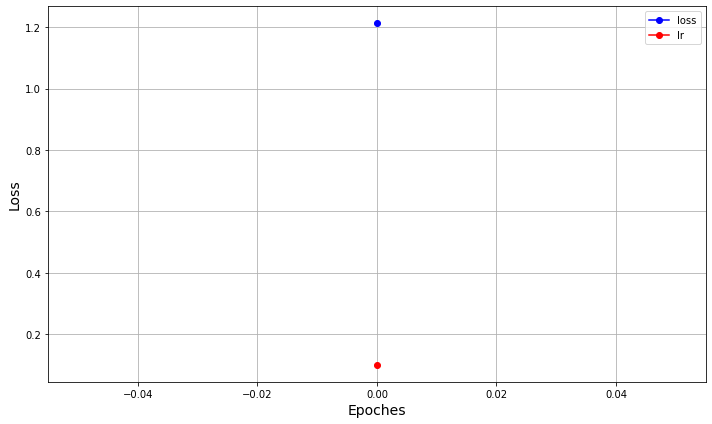

                      # Training with target domain data  #


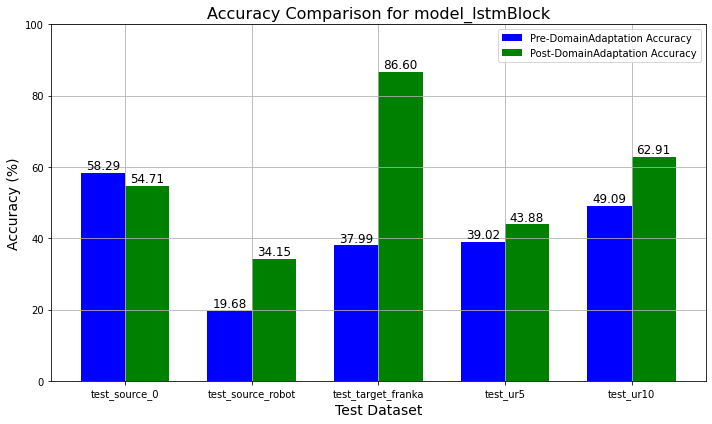

-----------------------------    model_lstmCNN ----------------------------- 


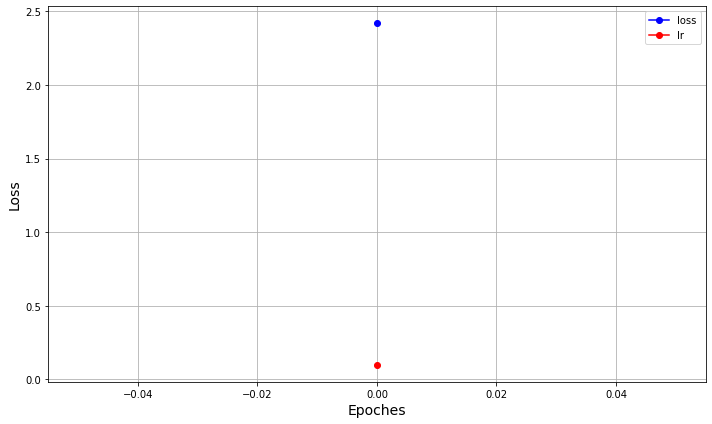

                      # Training with target domain data  #


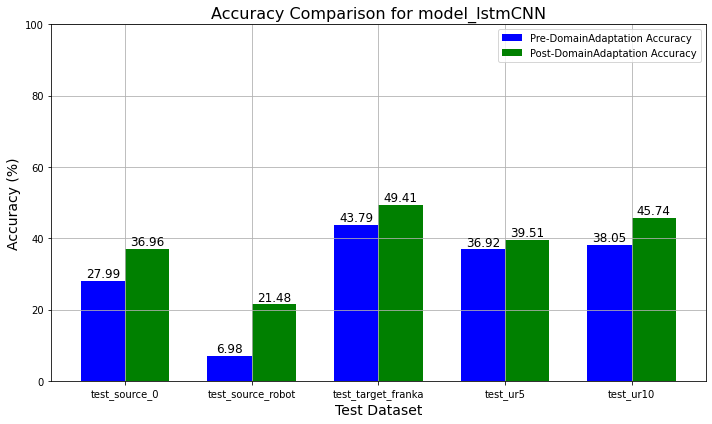

-----------------------------    model_cnnLSTM ----------------------------- 


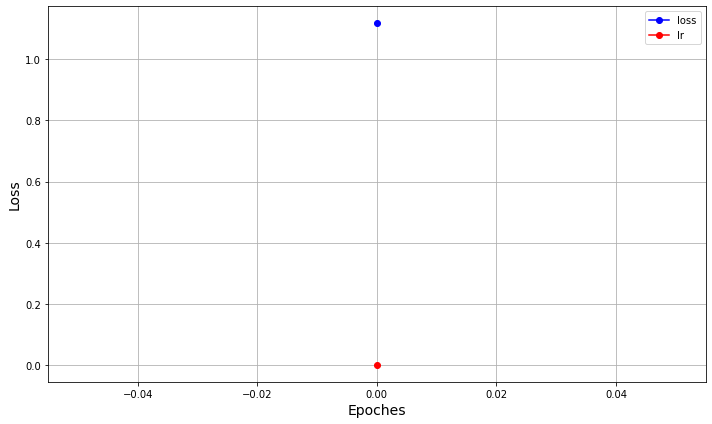

                      # Training with target domain data  #


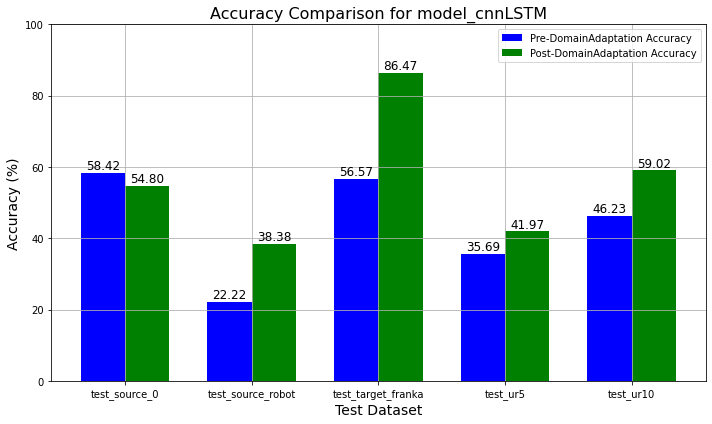

-----------------------------    model_cnnLSTMattention ----------------------------- 


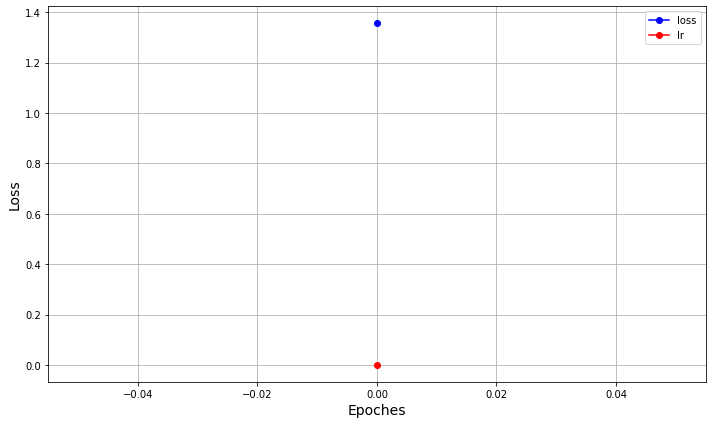

                      # Training with target domain data  #


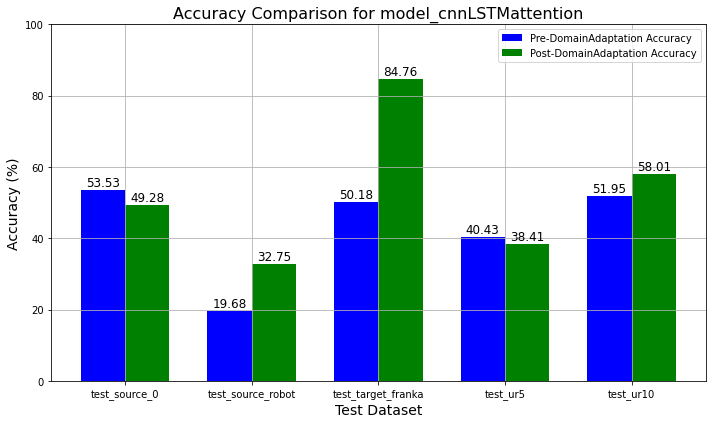

In [33]:
from torch.utils.data import random_split, DataLoader
def train_loop(model, dataloader, lr, n_epochs): #--> 
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    # Training loop
    for epoch in range(n_epochs):
        running_loss = []
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()  # Move data to device

            # Generate noise and shift as PyTorch tensors
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        
        avg_loss = np.mean(running_loss)
        #print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)

    return model, loss_seq, lr_seq

def plot_loss(loss_seq, lr_seq):
    # Plot the line chart
    plt.figure(figsize=(10, 6))  # High-quality figure size
    plt.plot(loss_seq, label='loss', color='blue', marker='o')
    plt.plot(lr_seq, label='lr', color='red', marker='o')


    # Labeling the chart
    plt.xlabel('Epoches', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    # Improve layout
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

def validation(dataloaders, names, model,print_data = False):
    model.eval()
    accuracies = []
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        accuracy_metric = Accuracy()
        for i in range(len(dataloaders)):
            y_pred, y_test = get_output(dataloaders[i], model, device)
            accuracy_metric.update(y_pred, y_test)
            accuracy = accuracy_metric.compute()
            if print_data: 
                print("Accuracy on ", names[i], ': ', accuracy)
            accuracies.append(accuracy.item()*100)  # Collect accuracy for plotting
            accuracy_metric.reset()
    return accuracies

# Bar chart plotting function
def plot_accuracies(pre_accuracies, post_accuracies, dataloader_names, model_name):
    labels = dataloader_names
    bar_width = 0.35
    index = range(len(labels))

    # Plotting the barchart
    plt.figure(figsize=(10, 6))
    plt.grid(True)

    bars1 = plt.bar(index, pre_accuracies, bar_width, label='Pre-DomainAdaptation Accuracy', color='blue')
    bars2 = plt.bar([i + bar_width for i in index], post_accuracies, bar_width, label='Post-DomainAdaptation Accuracy', color='green')

    # Set y-axis limits from 0 to 100
    plt.ylim(0, 100)

    # Adding labels, title, and legend
    plt.xlabel('Test Dataset', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)  # Indicating accuracy as a percentage
    plt.title(f'Accuracy Comparison for {model_name}', fontsize=16)
    plt.xticks([i + bar_width / 2 for i in index], labels)
    plt.legend()

    # Adding accuracy values on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

n_epochs = 60
n_epochs_da = 20

lr_threshold = 0.0005

for ii in range(len(models)):
    model = models[ii]
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    model, loss_seq, lr_seq = train_loop(model, train_dataloader, lr, n_epochs)
    plot_loss(loss_seq, lr_seq)
    
    # Validation
    pre_training_accuracies = validation(test_dataloaders, dataloaders_names, model)
    
    model_pre_trained = model
    print('                      # Training with target domain data  #')
    
    # Train on target domain and validate again
    post_training_accuracies = []
    for i in range(len(test_dataloaders)):
        dataset = test_dataloaders[i].dataset  # Extract the dataset from your existing DataLoader

        # Split the dataset: 10% for training, 90% for validation
        dataset_size = len(dataset)
        train_size = int(0.1 * dataset_size)
        val_size = dataset_size - train_size

        # Split the dataset
        target_train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Create new DataLoaders for training and validation sets
        target_train_dataloader = DataLoader(target_train_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=False)

        # Train on target domain data
        model, loss_seq, lr_seq = train_loop(model, target_train_dataloader, lr, n_epochs_da)

        # Validate on the same dataset and collect accuracies post-training
        post_training_accuracy = validation([val_dataloader], [dataloaders_names[i]], model)[0]
        post_training_accuracies.append(post_training_accuracy)
    
        # Reset model to pre-trained state if necessary
        model = model_pre_trained
    
    # Plot accuracy comparison for the current model
    plot_accuracies(pre_training_accuracies, post_training_accuracies, dataloaders_names, models_names[ii])



In [ ]:
lr=0.002
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# saving and loading models

In [ ]:
# test on source robot

model.eval()
with torch.no_grad():
    confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=7)
    accuracy_metric = Accuracy()

    # Update the metric with predictions and true labels
    
    y_pred, y_test = get_output(test_source_robot, model, device)
    print("On the test set:\n", confusionMatrix(y_pred,y_test))
    accuracy_metric.update(y_pred, y_test)
    print("Accuray on the test set:\n", accuracy_metric.compute())


# testing on second franka robot

In [ ]:

with torch.no_grad():
    confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    accuracy_metric = Accuracy()

    # Update the metric with predictions and true labels
    
    y_pred, y_test = get_output(test_target_franka, model, device)
    print("On the test set:\n", confusionMatrix(y_pred,y_test))
    accuracy_metric.update(y_pred, y_test)
    print("Accuray on the test set:\n", accuracy_metric.compute())

# testing on UR10 robot

In [ ]:

with torch.no_grad():
    confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=6)
    accuracy_metric = Accuracy()

    # Update the metric with predictions and true labels
    
    y_pred, y_test = get_output(test_ur10, model, device)
    print("On the test set:\n", confusionMatrix(y_pred,y_test))
    accuracy_metric.update(y_pred, y_test)
    print("Accuray on the test set:\n", accuracy_metric.compute())


# test on UR5 robot

In [ ]:


with torch.no_grad():
    confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=6)
    accuracy_metric = Accuracy()

    # Update the metric with predictions and true labels
    
    y_pred, y_test = get_output(test_ur5, model, device)
    print("On the test set:\n", confusionMatrix(y_pred,y_test))
    accuracy_metric.update(y_pred, y_test)
    print("Accuray on the test set:\n", accuracy_metric.compute())


# save the best model

In [ ]:
# Save the trained model
named_tuple = time.localtime()
if input('Do you want to save the data in trained models? (y/n): ') == 'y':
    try:
        if collision:
            path_name_1 = path_name + '/collisionDetection/trainedModel' + str(time.strftime("_%m_%d_%Y_%H:%M:%S", named_tuple)) + '.pth'
            path_name_2 = path_name + '/collisionDetection/trainedModel.pth'
        elif localization:
            path_name_1 = path_name + '/localization/trainedModel' + str(time.strftime("_%m_%d_%Y_%H:%M:%S", named_tuple)) + '.pth'
            path_name_2 = path_name + '/localization/trainedModel.pth'
        elif num_classes == 2:
            path_name_1 = path_name + '/contactDetection/trainedModel' + str(time.strftime("_%m_%d_%Y_%H:%M:%S", named_tuple)) + '.pth'
            path_name_2 = path_name + '/contactDetection/trainedModel.pth'

        torch.save({"model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "collision": collision, "localization": localization, "network_type": network_type,
                    "n_epochs": n_epochs, "batch_size": batch_size, "num_features_lstm": num_features_lstm,
                    "num_classes": num_classes, "lr": lr}, path_name_1)
        
        torch.save({"model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "collision": collision, "localization": localization, "network_type": network_type,
                    "n_epochs": n_epochs, "batch_size": batch_size, "num_features_lstm": num_features_lstm,
                    "num_classes": num_classes, "lr": lr}, path_name_2)
        print('Model saved successfully!')
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

In [ ]:
# Load Model
model_path= 'with_0.1_0.1_1_scheduler/model_92_50epoches.pth'

num_classes = 7
num_features_dataset=7
num_features_lstm=1
batch_size= 4096

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Build the model

model = Sequence(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.1)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.double().to(device)  # Move model to device

model.eval()

# Path to save trained models
model_path= 'model.pth'